# Basic description of the data sets

Data comes from [Bureau of Transportation Statistics (BTS)](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236). See [our data compiling](https://github.com/Morten-Esketveit/TSDS-gruppe-2019/blob/master/Exam/Data_compiling_v3.ipynb).

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

In [2]:
FlightsNx98 = pd.read_pickle("Data/FlightsNx98.pkl")
FlightsNx08 = pd.read_pickle("Data/FlightsNx07.pkl")
FlightsNx18 = pd.read_pickle("Data/FlightsNx18.pkl")

## US domestic flights data, cleaned

In [3]:
FlightsNx = FlightsNx18
print('Rows:', len(FlightsNx.index))
print(FlightsNx.columns)
print('There are {} unique departure airports in the dataset'.format(FlightsNx.Origin.nunique()))
print('There are {} unique destination airports in the dataset'.format(FlightsNx.Dest.nunique()))
FlightsNx["Journey"] = FlightsNx["Origin"]+FlightsNx["Dest"]
print('There are {} unique journeys in the dataset'.format(FlightsNx.Journey.nunique()))

Rows: 6225
Index(['Origin', 'Dest', 'Distance', 'count', 'avg_time_mins', 'companies',
       'Origin_flights', 'Destination_flights', 'origin_degree', 'dest_degree',
       'origin_btwns', 'dest_btwns', 'origin_clustcoef', 'dest_clustcoef'],
      dtype='object')
There are 355 unique departure airports in the dataset
There are 355 unique destination airports in the dataset
There are 6165 unique journeys in the dataset


### Using NetworkX

In [4]:
Network = nx.from_pandas_edgelist(FlightsNx, source = "Origin", target = "Dest", edge_attr = True)
print(nx.info(Network))

Name: 
Type: Graph
Number of nodes: 355
Number of edges: 3110
Average degree:  17.5211


### Sparse

In [5]:
# calculate L_max:  
print("L_max = {}".format(len(Network.nodes)*(len(Network.nodes)-1)*(1/2)))
print(2868/47895)

L_max = 62835.0
0.05988098966489195


### Degree distribution

In [6]:
degrees = pd.read_pickle("Data/Degrees18.pkl")

In [7]:
print('No. airports w. degree < 5:  ', len(degrees.loc[(degrees["degree_unnormalized"] < 5)].index))
print('No. airports w. degree > 100:', len(degrees.loc[(degrees["degree_unnormalized"] > 100)].index))

# See most connected airports in dataset
degrees.sort_values(by = "degree_unnormalized", ascending = False).head(10)

No. airports w. degree < 5:   163
No. airports w. degree > 100: 10


,degree,degree_unnormalized,airport
6,0.485876,172.0,ORD
25,0.468927,166.0,ATL
36,0.466102,165.0,DFW
15,0.457627,162.0,DEN
84,0.372881,132.0,CLT
51,0.370056,131.0,MSP
11,0.327684,116.0,LAS
1,0.322034,114.0,IAH
59,0.313559,111.0,DTW
5,0.290960,103.0,LAX


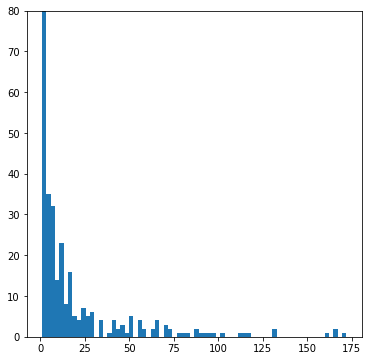

In [8]:
# Degree distribution
fig, ax = plt.subplots(figsize = (6,6))
plt.hist(degrees["degree_unnormalized"], bins = 70)
plt.ylim(0,80)
plt.show()

### Betweenness centrality

In [9]:
btwn = nx.betweenness_centrality(Network)
betweenness = list(btwn.values())
btwn_df = pd.DataFrame(betweenness)
btwn_df.columns = ["betweenness"]
btwn_df["airport"] = btwn.keys()

btwn_df.sort_values(by = "betweenness", ascending = False)
Node_char = degrees.merge(btwn_df, on= "airport")


Clustering Coefficient

In [10]:
clusters = nx.algorithms.cluster.clustering(Network)
clusters_df = pd.DataFrame(list(clusters.values()))
clusters_df.columns = ["clustering"]
clusters_df["airport"] = clusters.keys()
Node_char = Node_char.merge(clusters_df, on = "airport")

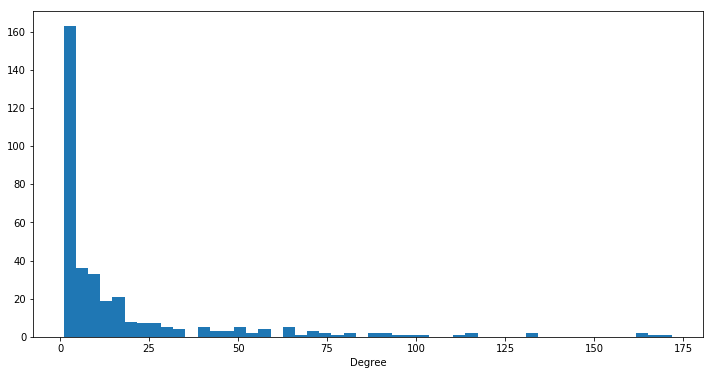

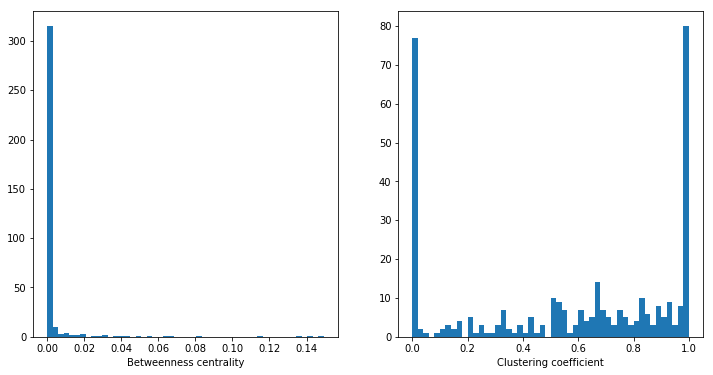

In [11]:
## Figure with degree distribution, betweenness centrality and clustering
fig, ax = plt.subplots(figsize = (12,6))

plt.hist(Node_char["degree_unnormalized"], bins = 50)
plt.xlabel("Degree")
plt.savefig(fname = "Figures/degreeDistribution.png", bbox_inches = "tight")
plt.show()

fig, ax = plt.subplots(figsize = (12,6))

plt.subplot(1,2,1)
plt.hist(Node_char["betweenness"], bins = 50)
plt.xlabel("Betweenness centrality")

plt.subplot(1,2,2)
plt.hist(Node_char["clustering"], bins = 50)
plt.xlabel("Clustering coefficient")
plt.savefig(fname = "Figures/Btwns_CC.png", bbox_inches = "tight")
plt.show()

#### (node) betweenness centrality vs degree

In [12]:
Node_char.head()

,degree,degree_unnormalized,airport,betweenness,clustering
0,0.220339,78.0,FLL,0.018337,0.399600
1,0.322034,114.0,IAH,0.038863,0.247322
2,0.231638,82.0,SEA,0.038347,0.394460
3,0.245763,87.0,SFO,0.028849,0.335472
4,0.248588,88.0,DCA,0.011112,0.352665


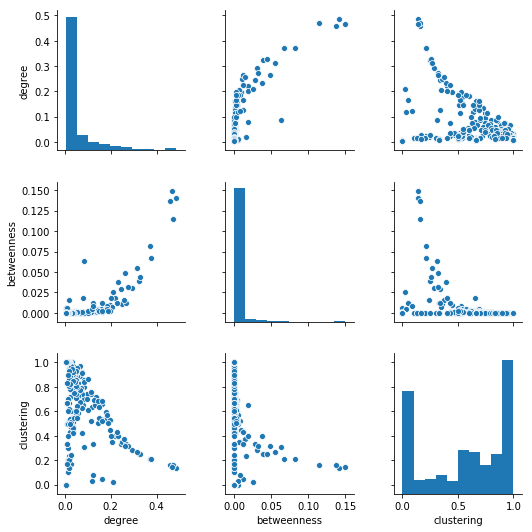

In [13]:
cols = ["degree","betweenness","clustering"]
sns.pairplot(Node_char[cols], height = 2.5)
plt.tight_layout()
plt.savefig(fname = "Figures/NxPairPlot.png")
plt.show()

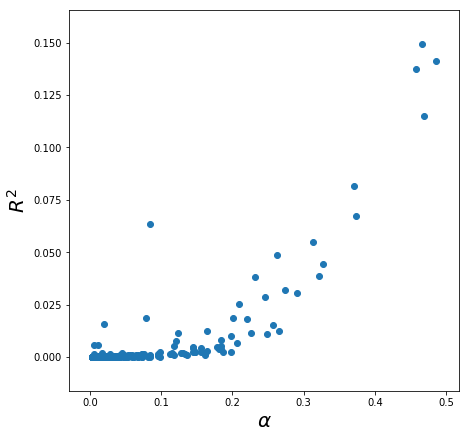

In [14]:
# Betweenness vs. degree
fig, ax = plt.subplots(figsize = (7,7))
plt.scatter(Node_char["degree"],Node_char["betweenness"])
plt.xlabel("$\\alpha$", fontsize = 20)
plt.ylabel("$R^2$", fontsize = 20)
plt.show()

### Measures for entire network

In [15]:
# print(nx.info(Network))
print("The average shortest path is: {}".format(nx.average_shortest_path_length(Network)))
print("The average clustering coefficient is: {}".format(nx.average_clustering(Network)))
print("The diameter of the network is: {}".format(nx.diameter(Network)))
print("The global efficiency of the network is: {}".format(nx.global_efficiency(Network)))

The average shortest path is: 2.387602450863372
The average clustering coefficient is: 0.5677439768425595
The diameter of the network is: 6
The global efficiency of the network is: 0.45555396408625337


### Shortest path length: Atlanta example

In [16]:
avg_shrt_path_len = nx.average_shortest_path_length(Network)
print(avg_shrt_path_len)

2.387602450863372


## US airports data

In [17]:
Airports = pd.read_pickle("Data/Airports.pkl")

# Get list of nodes, and add lat, lon from Airports dataset:
nodes = pd.DataFrame(list(Network.nodes()))
nodes.columns = ["3DigitId"]
positions = nodes.merge(Airports[["3DigitId","Lat","Lon"]], how = "left", on = "3DigitId")

print('No. airports in the openflights data:', len(Airports))
print('- of which missing 3DigitId:', Airports['3DigitId'].value_counts(dropna=False).nlargest(1)[0])
print('- of which containing 3DigitId:', Airports['3DigitId'].nunique())
print('No. airports within the network:', positions['3DigitId'].nunique())
positions.head(2)

No. airports in the openflights data: 1512
- of which missing 3DigitId: 261
- of which containing 3DigitId: 1252
No. airports within the network: 355


,3DigitId,Lat,Lon
0,FLL,26.072599,-80.152702
1,IAH,29.984400,-95.341400


In [18]:
test = pd.read_pickle("Scraping/missings_2018_del3.pkl")

In [19]:
test.shape

(720, 6)